In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
####################################################################################
# This is the main file to execute for the GPU run/save of the MCMC chain.
# Plotting options of the MCMC results at end of this notebook.
# Make sure the definitions in the other modules are correct. 
####################################################################################
import matplotlib.pyplot as plt
import cupy
from global_parameters import *  # Import physical constants, and other fixed quantities. 
from waveform import *  # Import GW equations and other functions. 

# We first compute the fiducial waveform model. Around it we perform the MCMC.
# x0: Vector with initial conditions at LSO for integration at given set of parameters.
# p0: Vector with fiducial parameters (mass, spin etc.).
# The values of x0, p0 are defined in global_parameters.py". 
# If more parameters are added both "global_parameters.py" and "waveform.py" need to be modified.

print(color.BLACK + 'fiducial parameters:  ' + color.END + str(parameter_names) + ' ' + ' = ' + str(p0))
fiducial_model = compute_fiducial(x0,p0)
print('Parameters: ' 'M = ', M0, ' ', 'μ =',  μ0, ' ', 'spin =', spin0, ' ', 'e_LSO =', e_LSO, ' ', 'νLSO =', nu_LSO)
print(color.GREEN + 'fiducial model computed' + color.END)

fiducial parameters:  ['Mass M', 'Mass μ', 'spin', 'Ξ']  = [1000000, 10, 0.1, 0.8]
Parameters: M =  1000000   μ = 10   spin = 0.1   e_LSO = 0.3   νLSO = 0.001653657453772231
fiducial model computed


### Plot the fiducial waveform, shortly before the plunge 

Parameters: M =  1000000   μ = 10   spin = 0.1   e_LSO = 0.3   νLSO = 0.001653657453772231


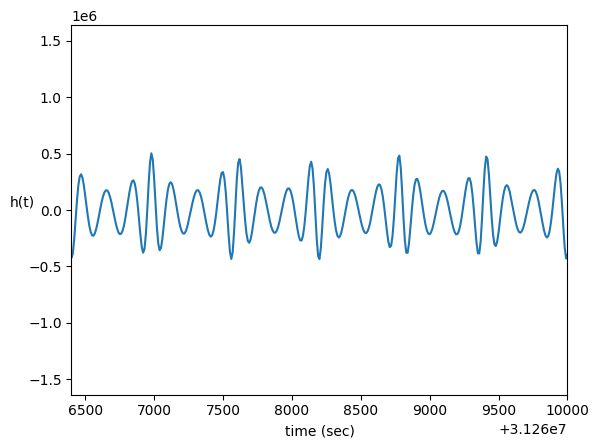

In [3]:
t_grid=cupy.float32(fiducial_model[0][0].get())
WF_grid=cupy.float32(fiducial_model[0][1].get())
hours = 1
#D      = 3.085678*10**(27)   #1Gpc
plot_waveform(t_grid, WF_grid, hours)
print('Parameters: ' 'M = ', M0, ' ', 'μ =',  μ0, ' ', 'spin =', spin0, ' ', 'e_LSO =', e_LSO, ' ', 'νLSO =', nu_LSO)
#plt.savefig('/home/oliveri/spin0.8_eLSO0.6.pdf', format='pdf', dpi=1200)

### Start the MCMC run

Things to be checked in the cell below (all others are set through the module .py files.)

-- Make sure the 'filename' where results will be stored is set up correctly.

-- Make sure the vector $p\_init\_MC$ with the initialisation range of the walkers is set up to meaningful values.



In [5]:
# The MCMC parameters (steps, walkers, etc) are defined in "global_parameters.py"
from mcmc import * 
import os

# Set up the backend to save the result of the MCMC in a txt file. File path needs adjustment.
# It will delete the file in case the file already exists before each MCMC run.
filename = "MCMC.txt"

if os.path.isfile(filename)==True: 
    os.remove(filename)
    print(color.RED + 'previous MCMC data file removed' + color.END)
    print(color.BOLD + 'data saved at: ' + filename + color.END)
    print(color.BLACK +'starting MCMC run .. '+  color.END)
backend = emcee.backends.HDFBackend(filename)
#backend.reset(Nwalker, Ndim)
########### 

# This is the vector defining the initial parameters for the walkers of the MCMC run.
# The value of each parameter is its fiducial value plus some small Gaussian noise.
# The dimension of p_init_MC must be equal to the number of walkers Nwalker.
# p_init_MC needs be modified for different set of parameters.
p_init_MC = np.random.randn(Nwalker, Ndim)*[1, 1*(10**-5), 2*(10**-6),1*(10**-5)] + [M0, μ0, spin0,Xi0]
########### 

# Use these for not-parallelised walkers. This makes the MCMC run slower.
#sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, backend=backend)
#pos, prob, state = sampler.run_mcmc(p_init_MC, Nsteps, progress=True)

multiprocessing.set_start_method('spawn', force=True) 
from multiprocessing import set_start_method
if __name__ == "__main__":
    multiprocessing.set_start_method('spawn', force=True)
    with Pool(processes= Nwalker) as pool:
        sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, backend=backend, pool = pool)
        pos, prob, state = sampler.run_mcmc(p_init_MC, Nsteps, progress=True)               

 66%|██████▌   | 1323/2000 [1:27:47<44:45,  3.97s/it]  

### Plot the MCMC results

This plots the MCMC results (corner plot, histograms, etc.).

-- Make sure the 'filename' with the results to be loaded is set up correctly.

-- Make sure the burnout option ('burn') is chosen appropriately.


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import emcee

# Read the txt file ("filename") created above to produce the plots. 
# Filename is defined above and saved in local folder. Its data are produced during the MCMC run.

burn = 500
reader = emcee.backends.HDFBackend(filename, read_only=True)
samples = reader.get_chain(flat=True, discard=burn)

dsb = np.array([samples[:,0],samples[:,1],samples[:,2],samples[:,3]])
df = pd.DataFrame(dsb.T,columns = [r'$M$', r'$\mu$',  r'$\frac{S}{M^2}$',  r'$\Xi$'])

plt.figure()
#with plt.style.context({'axes.labelsize':20}):
g = sns.PairGrid(df, diag_sharey=True,corner=True)
g.map_lower(sns.scatterplot, alpha=1, edgecolor='none', s = 0.09, color = 'tomato')
g.map_diag(sns.histplot,  element="step", color = 'blanchedalmond')
plt.savefig('/home/oliveri/corner_plot.png', format='png')

In [ ]:
from IPython.display import display, Math

labels = parameter_names
for i in range(len(labels)):
    mcmc = np.percentile(samples[:, i], [50, 80, 90])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))